In [2]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from lightgbm import LGBMRegressor
from econml.metalearners import SLearner
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def generate_data(n, p, seed=42):
    np.random.seed(seed)
    features = np.random.normal(size=(n, p))
    df = pd.DataFrame(features, columns=[f"x_{i}" for i in range(p)])
    x_cols = df.columns.to_list()
    return df, x_cols

def generate_treatment(df, x_cols, seed=42):
    np.random.seed(seed)
    logistic_model = LogisticRegression(max_iter=1000)
    df["target"] = (np.dot(df[x_cols].values, np.random.uniform(0.1, 0.5, size=len(x_cols))) - 0.5 + np.random.normal(0, 0.5, size = len(df)) > 0).astype(int)
    logistic_model.fit(df[x_cols], df["target"])
    df["T_prob"] = logistic_model.predict_proba(df[x_cols])[:, 1]
    df["T_prob"] = df["T_prob"].clip(0.01, 0.99)
    df["T"] = np.random.binomial(1, df["T_prob"])
    df.drop("target", axis=1, inplace=True)
    return df

# T_Probを予測値に変更
def predict_treatment(df, x_cols):
    logistic_model = LogisticRegression(max_iter=1000)
    logistic_model.fit(df[x_cols], df["T"])
    df["T_prob"] = logistic_model.predict_proba(df[x_cols])[:, 1]
    df["T_prob"] = df["T_prob"].clip(0.01, 0.99)
    return df

def generate_visit(df, x_cols, seed=42):
    np.random.seed(seed)
    interaction_effects = sigmoid(np.sum(df.iloc[:, :len(x_cols)], axis=1))
    baseline_effect = 0.3 + df['x_2'] * 0.4 + df["x_4"] * 0.1
    treatment_effect = df['T'] * (0.4 + interaction_effects)
    noise = np.random.normal(0, 0.5)
    prob_visit = np.clip(baseline_effect + treatment_effect + noise, 0, 1)
    df['visit'] = np.random.binomial(1, prob_visit)
    return df

def generate_conversion(df, x_cols, seed=42):
    np.random.seed(seed)
    interaction_effects_purchase = sigmoid(np.sum(df.iloc[:, :len(x_cols)], axis=1))
    baseline_effect_purchase = 0.1 + df['x_5'] * 0.3 + df["x_7"] * 0.3
    treatment_effect_purchase = df['T'] * (0.2 + interaction_effects_purchase)
    noise = np.random.normal(0, 0.5)
    prob_purchase = np.clip(baseline_effect_purchase + treatment_effect_purchase + noise, 0, 1)
    df['purchase'] = np.where(df['visit'] == 1, np.random.binomial(1, prob_purchase), 0)
    return df

def predict_outcome(df, x_cols):
    df_t0 = df[df["T"]==0]
    df_t1 = df[df["T"]==1]
    mu_r_0 = LGBMRegressor().fit(df_t0[x_cols], df_t0["purchase"])
    mu_r_1 = LGBMRegressor().fit(df_t1[x_cols], df_t1["purchase"])
    mu_c_0 = LGBMRegressor().fit(df_t0[x_cols], df_t0["visit"])
    mu_c_1 = LGBMRegressor().fit(df_t1[x_cols], df_t1["visit"])
    return mu_r_0, mu_r_1, mu_c_0, mu_c_1

def preprocess_data(df, x_cols, mu_r_0, mu_r_1, mu_c_0, mu_c_1):
    X, T, y_r, y_c = df[x_cols], df["T"], df["purchase"], df["visit"]
    df["y_r_ipw"] = np.where(df["T"]==1, df["purchase"] / df["T_prob"], df["purchase"] / (1 - df["T_prob"]))
    df["y_c_ipw"] = np.where(df["T"]==1, df["visit"] / df["T_prob"], df["visit"] / (1 - df["T_prob"]))
    df["y_c_dr"] = np.where(T==1, (df["visit"] - mu_c_1.predict(X)) / df["T_prob"] + mu_c_1.predict(X), (df["visit"] - mu_c_0.predict(X)) / (1 - df["T_prob"]) + mu_c_0.predict(X))
    df["y_r_dr"] = np.where(T==1, (df["purchase"] - mu_r_1.predict(X)) / df["T_prob"] + mu_r_1.predict(X), (df["purchase"] - mu_r_0.predict(X)) / (1 - df["T_prob"]) + mu_r_0.predict(X))
    return df, X, T, y_r, y_c

def split_data(df, x_cols, X, T, y_r, y_c):
    X_train, X_test, T_train, T_test, y_r_train, y_r_test, y_c_train, y_c_test, y_r_dr_train, y_r_dr_test, y_c_dr_train, y_c_dr_test, y_r_ipw_train, y_r_ipw_test, y_c_ipw_train, y_c_ipw_test = train_test_split(
        X, T, y_r, y_c, df["y_r_dr"], df["y_c_dr"], df["y_r_ipw"], df["y_c_ipw"], train_size=0.7, random_state=0, stratify=T
        )

    T_test = T_test.reset_index(drop=True)
    y_r_test = y_r_test.reset_index(drop=True)
    y_c_test = y_c_test.reset_index(drop=True)

    return X_train, X_test, T_train, T_test, y_r_train, y_r_test, y_c_train, y_c_test, y_r_dr_train, y_r_dr_test, y_c_dr_train, y_c_dr_test, y_r_ipw_train, y_r_ipw_test, y_c_ipw_train, y_c_ipw_test

def import_loader(X_train, y_r_train, y_c_train, T_train):
    X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
    y_r_train_tensor = torch.tensor(y_r_train.values, dtype=torch.float32)
    y_c_train_tensor = torch.tensor(y_c_train.values, dtype=torch.float32)
    T_train_tensor = torch.tensor(T_train.values, dtype=torch.float32)
    dataset_1 = TensorDataset(X_train_tensor[T_train_tensor == 1], y_r_train_tensor[T_train_tensor == 1], y_c_train_tensor[T_train_tensor == 1])
    dataset_0 = TensorDataset(X_train_tensor[T_train_tensor == 0], y_r_train_tensor[T_train_tensor == 0], y_c_train_tensor[T_train_tensor == 0])
    loader_1 = DataLoader(dataset_1, batch_size=128, shuffle=True)
    loader_0 = DataLoader(dataset_0, batch_size=128, shuffle=True)
    return loader_1, loader_0

class NonLinearModel(nn.Module):
    def __init__(self, input_dim):
        super(NonLinearModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, 30)
        self.fc2 = nn.Linear(30, 15)
        self.fc3 = nn.Linear(15, 5)
        self.fc4 = nn.Linear(5, 1)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.sigmoid(self.fc4(x))
        return x

def custom_loss(y_r, y_c, q, group_size):
    q = torch.clamp(q, 1e-8, 1 - 1e-8)
    logit_q = torch.log(q / (1 - q))
    loss = -torch.sum(y_r * logit_q + y_c * torch.log(1 - q)) / group_size
    return loss

def get_loss(num_epochs, lr, loader_1, loader_0, X_train):
    model = NonLinearModel(X_train.shape[1])
    optimizer = optim.Adam(model.parameters(), lr=lr)
    loss_history = []

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        count_batches = 0

        for (x_1, y_r_1, y_c_1), (x_0, y_r_0, y_c_0) in tqdm(zip(loader_1, loader_0)):
            optimizer.zero_grad()
            q_1 = model(x_1)
            q_0 = model(x_0)
            loss_1 = custom_loss(y_r_1, y_c_1, q_1, x_1.size(0))
            loss_0 = custom_loss(y_r_0, y_c_0, q_0, x_0.size(0))
            loss = loss_1 - loss_0
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            count_batches += 1

        average_loss = total_loss / count_batches
        loss_history.append(average_loss)
        if epoch % 10 == 0:
            print(f'Epoch {epoch}, Average Loss: {average_loss}')
    return model, loss_history

# 損失の推移の可視化
def plot_loss(loss_history):
    plt.figure(figsize=(10, 6))
    plt.plot(loss_history)
    plt.title('Loss Transition')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.show()

def get_roi(model, X_test):
    model.eval()
    with torch.no_grad():
        q_test = model(torch.tensor(X_test.values, dtype=torch.float32))
        roi_direct = q_test.numpy()
        roi_direct = roi_direct.reshape(1, -1)[0]
        return roi_direct

def get_roi_tpmsl(X_train, X_test, y_r_train, y_c_train, T_train, y_r_test, y_c_test):
    # モデルの構築
    models = LGBMRegressor()
    # models = LinearRegression()
    S_learner_r = SLearner(overall_model = models)
    S_learner_r.fit(y_r_train, T_train, X = X_train)

    S_learner_c = SLearner(overall_model = models)
    S_learner_c.fit(y_c_train, T_train, X = X_train)

    # 効果の推定
    tau_r = S_learner_r.effect(X_test)
    tau_c = S_learner_c.effect(X_test)
    roi_tpmsl = tau_r / tau_c

    scaler = MinMaxScaler()
    roi_tpmsl = scaler.fit_transform(roi_tpmsl.reshape(-1, 1)).flatten()

    # roi_tpmsl = sigmoid(roi_tpmsl)
    return roi_tpmsl

def calculate_values(roi_scores, T_test, y_r_test, y_c_test):
    sorted_indices = np.argsort(roi_scores)[::-1]
    p_values = np.linspace(0, 1, 30)
    incremental_costs = []
    incremental_values = []
    
    for p in p_values:
        top_p_indices = sorted_indices[:int(p * len(roi_scores))]
        treatment_indices = (T_test[top_p_indices] == 1)
        
        # ATE (Average Treatment Effect) の計算
        ATE_Yr = np.mean(y_r_test[top_p_indices][treatment_indices]) - np.mean(y_r_test[top_p_indices][~treatment_indices])
        ATE_Yc = np.mean(y_c_test[top_p_indices][treatment_indices]) - np.mean(y_c_test[top_p_indices][~treatment_indices])
        
        incremental_costs.append(ATE_Yc * np.sum(treatment_indices))
        incremental_values.append(ATE_Yr * np.sum(treatment_indices))
        # print(ATE_Yr , ATE_Yc,np.sum(treatment_indices))
        incremental_costs[0] = 0
        incremental_values[0] = 0
        
    return incremental_costs, incremental_values

def plot_cost_curve(data_dict):
    plt.figure(figsize=(10, 6))
    
    # 辞書をループして各データセットをプロット
    for label, (costs, values) in data_dict.items():
        plt.plot(costs / max(costs), values / max(values), label=label)
    
    # 基準線の追加
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    
    # グラフのタイトルと軸ラベルを設定
    plt.title('Cost Curve Comparison')
    plt.xlabel('Incremental Cost')
    plt.ylabel('Incremental Value')
    
    # 凡例とグリッドを表示
    plt.legend()
    plt.grid(True)
    plt.show()

def main(predict_ps=True):
    print("Predict PS:")
    seed = 42
    n = 10_000_000
    p = 10
    num_epochs = 50
    lr = 0.001
    df, x_cols = generate_data(n, p, seed)
    df = generate_treatment(df, x_cols, seed)
    df["T_prob"].hist(alpha=0.3, bins=30)
    if predict_ps:
        df = predict_treatment(df, x_cols)
        # df["T_prob"].hist(alpha=0.3, bins=30)
    df = generate_visit(df, x_cols)
    df = generate_conversion(df, x_cols)
    mu_r_0, mu_r_1, mu_c_0, mu_c_1 = predict_outcome(df, x_cols)
    print("Predict Outcome:")
    df, X, T, y_r, y_c = preprocess_data(df, x_cols, mu_r_0, mu_r_1, mu_c_0, mu_c_1)
    print("Preprocess Data:")
    X_train, X_test, T_train, T_test, y_r_train, y_r_test, y_c_train, y_c_test, y_r_dr_train, y_r_dr_test, y_c_dr_train, y_c_dr_test, y_r_ipw_train, y_r_ipw_test, y_c_ipw_train, y_c_ipw_test = split_data(df, x_cols, X, T, y_r, y_c)
    print("Split Data:")
    loader_1_dr, loader_0_dr = import_loader(X_train, y_r_dr_train, y_c_dr_train, T_train)
    print("Import Loader:")
    # loader_1_ipw, loader_0_ipw = import_loader(X_train, y_r_ipw_train, y_c_ipw_train, T_train)
    # loader_1, loader_0 = import_loader(X_train, y_r_train, y_c_train, T_train)
    model_dr, loss_history_dr = get_loss(num_epochs, lr, loader_1_dr, loader_0_dr, X_train)
    # model_ipw, loss_history_ipw = get_loss(num_epochs, lr, loader_1_ipw, loader_0_ipw, X_train)
    # model_naive, loss_history_naive = get_loss(num_epochs, lr, loader_1, loader_0, X_train)
    plot_loss(loss_history_dr)
    # plot_loss(loss_history_ipw)
    # plot_loss(loss_history_naive)
    roi_direct_dr = get_roi(model_dr, X_test)
    # roi_direct_ipw = get_roi(model_ipw, X_test)
    # roi_direct_naive = get_roi(model_naive, X_test)
    roi_tpmsl = get_roi_tpmsl(X_train, X_test, y_r_train, y_c_train, T_train, y_r_test, y_c_test)
    data_dict = {
        'Direct DR': calculate_values(roi_direct_dr, T_test, y_r_test, y_c_test),
        # 'Direct IPW': calculate_values(roi_direct_ipw, T_test, y_r_test, y_c_test),
        # 'Direct Naive': calculate_values(roi_direct_naive, T_test, y_r_test, y_c_test),
        'TPMSL': calculate_values(roi_tpmsl, T_test, y_r_test, y_c_test)
    }
    plot_cost_curve(data_dict)

In [3]:
seed = 42
n = 10_000_000
p = 10
num_epochs = 50
lr = 0.001
df, x_cols = generate_data(n, p, seed)
df = generate_treatment(df, x_cols, seed)
df = generate_visit(df, x_cols)
df = generate_conversion(df, x_cols)
mu_r_0, mu_r_1, mu_c_0, mu_c_1 = predict_outcome(df, x_cols)
df, X, T, y_r, y_c = preprocess_data(df, x_cols, mu_r_0, mu_r_1, mu_c_0, mu_c_1)
X_train, X_test, T_train, T_test, y_r_train, y_r_test, y_c_train, y_c_test, y_r_dr_train, y_r_dr_test, y_c_dr_train, y_c_dr_test, y_r_ipw_train, y_r_ipw_test, y_c_ipw_train, y_c_ipw_test = split_data(df, x_cols, X, T, y_r, y_c)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.025227 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 6657806, number of used features: 10
[LightGBM] [Info] Start training from score 0.145016
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015258 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 3342194, number of used features: 10
[LightGBM] [Info] Start training from score 0.953015
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.024609 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not e

In [4]:
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_r_train_tensor = torch.tensor(y_r_train.values, dtype=torch.float32)
y_c_train_tensor = torch.tensor(y_c_train.values, dtype=torch.float32)
T_train_tensor = torch.tensor(T_train.values, dtype=torch.float32)

In [4]:
# loader_1の中身を確認
for x, y_r, y_c in loader_1:
    print(x)
    print(y_r)
    print(y_c)
    break

In [5]:
model = NonLinearModel(X_train.shape[1])
optimizer = optim.Adam(model.parameters(), lr=lr)
loss_history = []

for epoch in tqdm(range(num_epochs)):
    model.train()
    total_loss = 0
    count_batches = 0

    for (x_1, y_r_1, y_c_1), (x_0, y_r_0, y_c_0) in tqdm(zip(loader_1, loader_0)):
        optimizer.zero_grad()
        print(x_1.size(0), x_0.size(0))
        q_1 = model(x_1)
        q_0 = model(x_0)
        print(q_1, q_0)
        loss_1 = custom_loss(y_r_1, y_c_1, q_1, x_1.size(0))
        loss_0 = custom_loss(y_r_0, y_c_0, q_0, x_0.size(0))
        loss = loss_1 - loss_0
        print(loss.item())
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        count_batches += 1

    average_loss = total_loss / count_batches
    loss_history.append(average_loss)
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Average Loss: {average_loss}')


  0%|          | 0/50 [00:00<?, ?it/s]

In [4]:
model_dr, loss_history_dr = get_loss(num_epochs, lr, loader_1, loader_0, X_train)
# model_ipw, loss_history_ipw = get_loss(num_epochs, lr, loader_1_ipw, loader_0_ipw, X_train)
# model_naive, loss_history_naive = get_loss(num_epochs, lr, loader_1, loader_0, X_train)
plot_loss(loss_history_dr)
# plot_loss(loss_history_ipw)
# plot_loss(loss_history_naive)
roi_direct_dr = get_roi(model_dr, X_test)
# roi_direct_ipw = get_roi(model_ipw, X_test)
# roi_direct_naive = get_roi(model_naive, X_test)
roi_tpmsl = get_roi_tpmsl(X_train, X_test, y_r_train, y_c_train, T_train, y_r_test, y_c_test)
data_dict = {
    'Direct DR': calculate_values(roi_direct_dr, T_test, y_r_test, y_c_test),
    # 'Direct IPW': calculate_values(roi_direct_ipw, T_test, y_r_test, y_c_test),
    # 'Direct Naive': calculate_values(roi_direct_naive, T_test, y_r_test, y_c_test),
    'TPMSL': calculate_values(roi_tpmsl, T_test, y_r_test, y_c_test)
}
plot_cost_curve(data_dict)

0it [00:00, ?it/s]

In [1]:
import non_RCT_NN
import importlib
importlib.reload(non_RCT_NN)
non_RCT_NN.main(predict_ps=False)

Predict PS:
Predict Outcome:
Preprocess Data:
Split Data:
Import Loader:


0it [00:00, ?it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020521 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 6657806, number of used features: 10
[LightGBM] [Info] Start training from score 0.145016
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011395 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 3342194, number of used features: 10
[LightGBM] [Info] Start training from score 0.953015
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020719 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not e

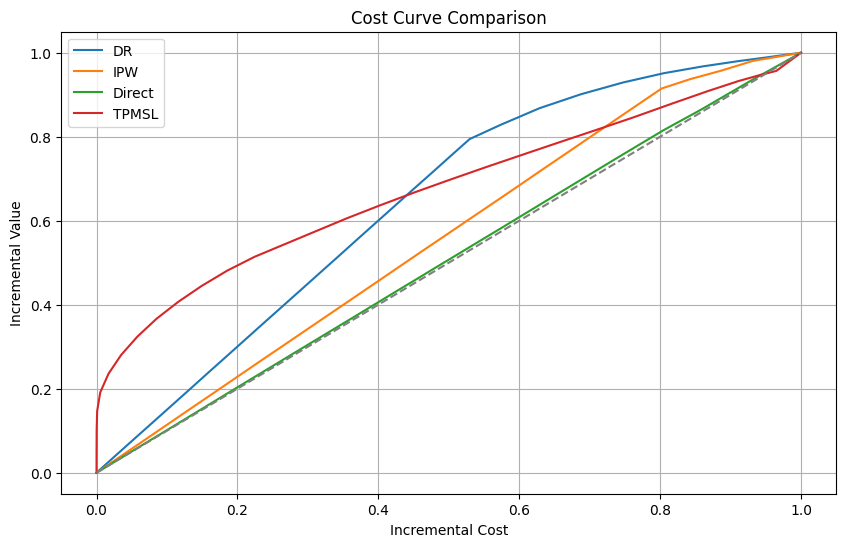

In [4]:
import non_RCT
import importlib
importlib.reload(non_RCT)
non_RCT.main()

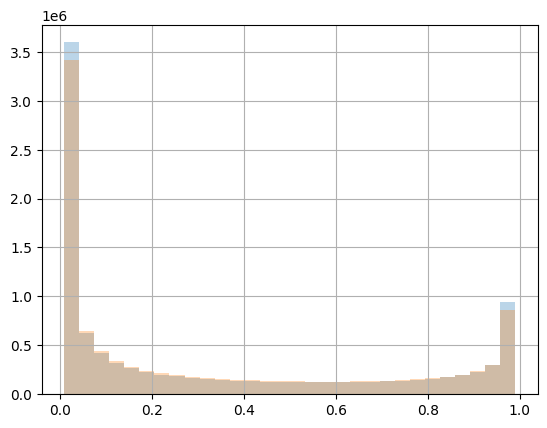

In [9]:
import non_RCT
import importlib
importlib.reload(non_RCT)
non_RCT.main()